# Ensemble-based Post-Processing

Here we experiment with using an ensemble of outputs (e.g. from different segmentation routines) to assemble an overall estimate for OCT boundaries.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat

# note: GPy does not come with anaconda, so you will have to install manually
import GPy

sys.path.append('../..')
import cnn_tools as ct
import train_oct
import postproc_oct as ppo

Using TensorFlow backend.


## Loading Data

Load sample data generated by Neil.  Dimensions are:

- 8 different CNN models
- 10 separate images
- 7 possible classes per pixel
- 512 rows
- 769 columns

In [63]:
f = np.load('Y_ensemble_results.npz')
print(f.keys())

Y_hat = f['Y_hat_raw_per_model']
X = f['X']
print(Y_hat.shape)
print(X.shape)

['Y_hat_per_model', 'Y_hat_raw_ensemble_mean', 'Y_hat_ensemble_mean', 'Y', 'X', 'Y_hat_raw_per_model', 'Y_hat_ensemble_std']
(8, 10, 7, 512, 768)
(10, 1, 512, 768)


## Preliminary Analysis
Here we explore the data a little bit.

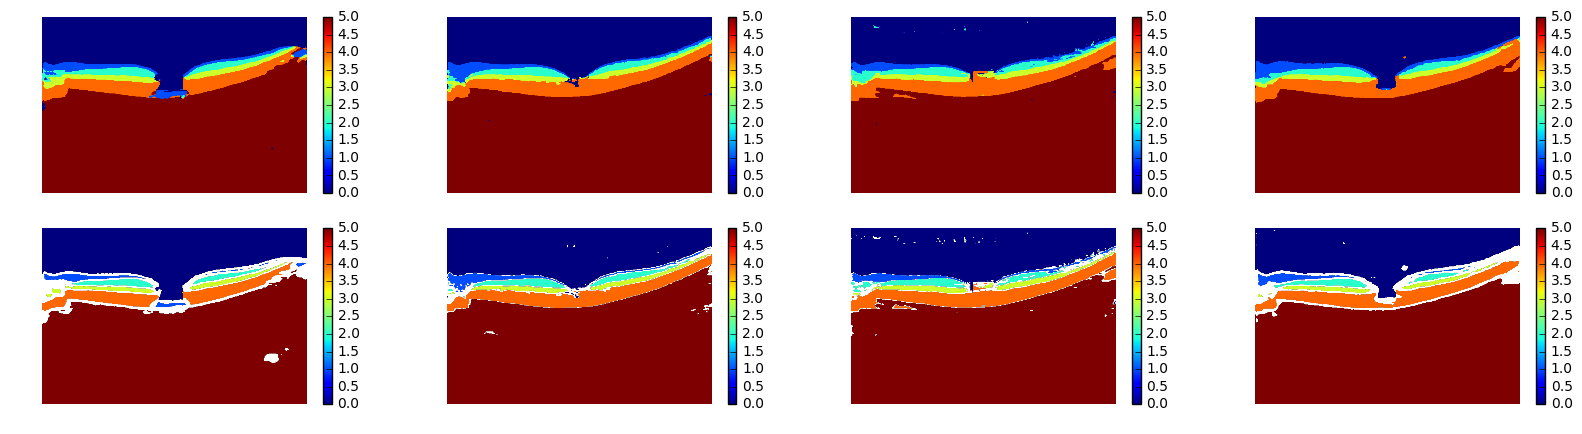

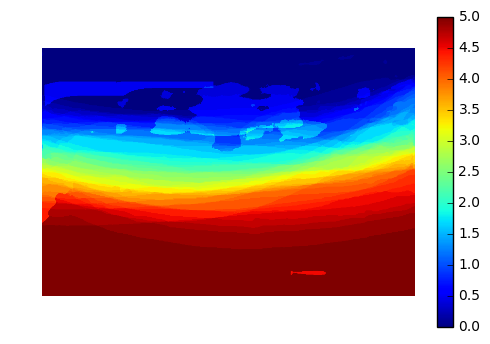

In [26]:
img_idx = 0
n = 4

# look at a few individual estimates
plt.figure(figsize=(20,5))
for model_idx in range(n):
    yi_prob = Y_hat[model_idx, img_idx, ...]
    yi_hat = np.argmax(yi_prob, axis=0)
    
    # show only the "high confidence" pixels/estimates
    mask = np.max(yi_prob, axis=0) > .8
    yi_hat_highconf = np.copy(yi_hat).astype(np.float32)
    yi_hat_highconf[~mask] = np.nan
     

    plt.subplot(2,n,model_idx+1);  
    plt.imshow(yi_hat);  plt.axis('off'); plt.colorbar()
    
    plt.subplot(2,n,n+model_idx+1);  
    plt.imshow(yi_hat_highconf);  plt.axis('off'); plt.colorbar()
    
# look at averaged result
y_avg = np.mean(np.argmax(Y_hat[model_idx,...], axis=1), axis=0)
plt.figure()
plt.imshow(y_avg);  plt.axis('off'); plt.colorbar()

plt.show()


In [ ]:
# Let's see what happens if we just take all points from all models at once.

img_idx = 0
x_eval = np.arange(768)
y_hat_all = []

for boundary_idx in range(5):
    # aggregate estimates across all models
    estimates = [ppo.get_class_transitions(np.argmax(Y_hat[j, img_idx, ...], axis=0), boundary_idx)
                                           for j in range(Y_hat.shape[0])]

    estimates = np.concatenate(estimates, axis=0)
    print(estimates.shape)
    
    if boundary_idx >= 2:
        kern = GPy.kern.RBF(input_dim=1, variance=20, lengthscale=50)
    else:
        kern = GPy.kern.RBF(input_dim=1, variance=20, lengthscale=80)

    tic = time.time()
    y_hat = ppo.boundary_regression_1d(estimates[:,1], estimates[:,0], x_eval, kern)
    y_hat_all.append(y_hat)
    print('runtime for boundary %d: %0.2f sec' % (boundary_idx, time.time() - tic))

 
    plt.figure()
    plt.plot(estimates[:,1], estimates[:,0], 'bo', x_eval, y_hat, 'r-')
    plt.gca().invert_yaxis()
    plt.title('boundary %d' % boundary_idx)

(5855, 2)
runtime for boundary 0: 18.12 sec
(5917, 2)
runtime for boundary 1: 18.97 sec
(5697, 2)


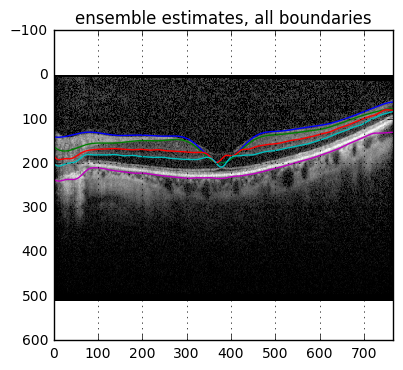

In [75]:
# let's look at some aggregate results

plt.figure()
plt.imshow(np.squeeze(X[img_idx,...]), interpolation='none', cmap='gray')

for ii in range(len(y_hat_all)):
    plt.plot(x_eval, y_hat_all[ii])
#plt.gca().invert_yaxis()  # not needed if plotting underlying image
plt.grid('on')
plt.title('ensemble estimates, all boundaries')
plt.xlim([0, np.max(x_eval)])
plt.show()